In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression

In [3]:
train = pd.read_csv("Train.csv")
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
train.shape

(8523, 12)

In [5]:
#checking for the  null values in train data
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### It is seen that Item_Weight and Outlet_Size have the max number of null values but we cannot drop them right away as we do not know whether it has any significance on the dependent variable.

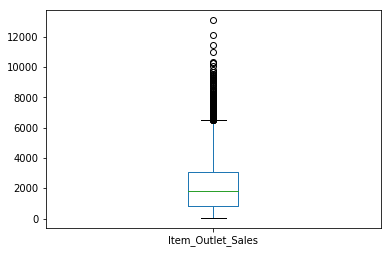

In [6]:
#checking for outiers
train.Item_Outlet_Sales.plot(kind='box')

* We can clearly observe the outliers
* Maximum values of the response variable sales price lies above 7000 

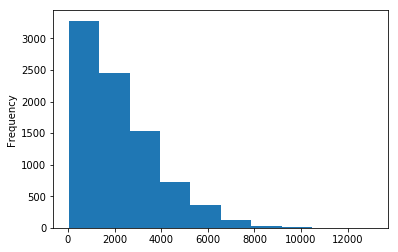

In [7]:
train.Item_Outlet_Sales.plot(kind="hist")
plt.show()

* Here we can see that they are positively skewed to the right
* Apply sqrt or log transformation to normalise them

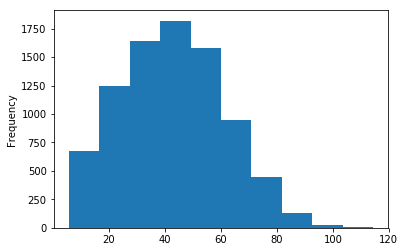

In [8]:
np.sqrt(train.Item_Outlet_Sales).plot(kind='hist')
plt.show()

#### It is seen that the data has been normalised to an extent.

In [9]:
#dropping Item_Identifier and Outlet_Identifier as it wont make difference in sales prediction
train.drop('Item_Identifier',axis=1,inplace=True)

In [10]:
train.drop('Outlet_Identifier',axis=1,inplace=True)

In [11]:
train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [12]:
train.shape

(8523, 10)

In [13]:
#impute missing value in column "Item_Weight" by using KNN imputation
from missingpy import KNNImputer
imputer=KNNImputer(missing_values='NaN',n_neighbors=3,metric='masked_euclidean')
train['Item_Weight']=imputer.fit_transform(train[['Item_Weight']])

In [14]:
#checking whether any null value exists
train.Item_Weight.isnull().sum()

0

In [15]:
#missing values in outlet_size
train.Outlet_Size.value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [16]:
#replace Nan with small
train['Outlet_Size']=train['Outlet_Size'].replace({np.nan:'Small'})
#checking whether null values exist still
train.Outlet_Size.isnull().sum()

0

In [17]:
#checking frequency of items in item_fats
train.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [18]:
#replace lowfat,regular,Low Fat,reg
train['Item_Fat_Content']=train['Item_Fat_Content'].replace({'Low Fat':'LF','low fat':'LF','Regular':'RF','reg':'RF'})

In [19]:
train.Item_Fat_Content.value_counts()

LF    5517
RF    3006
Name: Item_Fat_Content, dtype: int64

In [20]:
#checking the items in item_type
train.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [21]:
#grouping the items
train['Item_Type']=train['Item_Type'].replace({'Fruits and Vegetables':'grocery','Snack Foods':'snacks',
             'Household':'grocery','Frozen Foods':'snacks','Dairy':'grocery','Canned':'grocery','Baking Goods':'grocery',
            'Health and Hygiene':'health','Soft Drinks':'drinks','Meat':'grocery','Breads':'grocery','Hard Drinks':'drinks',
            'Others':'others','Starchy Foods':'others','Breakfast':'others','Seafood':'grocery'})

In [22]:
train.Item_Type.value_counts()

grocery    4861
snacks     2056
drinks      659
health      520
others      427
Name: Item_Type, dtype: int64

In [23]:
#converting Outlet_Establishment_Year to numerical columns by calcualting no.of years
train['Outlet_Establishment_Year']=2019-train.Outlet_Establishment_Year
train.Outlet_Establishment_Year

0       20
1       10
2       20
3       21
4       32
5       10
6       32
7       34
8       17
9       12
10      20
11      22
12      20
13      22
14      32
15      22
16      10
17      20
18      34
19      15
20      32
21      34
22      15
23      34
24      22
25      12
26      15
27      32
28      21
29      34
        ..
8493    12
8494    12
8495    15
8496    12
8497    15
8498    10
8499    15
8500    12
8501    12
8502    17
8503    15
8504    34
8505    10
8506    10
8507    15
8508    17
8509    21
8510    15
8511    10
8512    32
8513    15
8514    17
8515    10
8516    10
8517    22
8518    32
8519    17
8520    15
8521    10
8522    22
Name: Outlet_Establishment_Year, Length: 8523, dtype: int64

In [24]:
train.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [25]:
train.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [26]:
data=train
data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,LF,0.016047,grocery,249.8092,20,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,RF,0.019278,drinks,48.2692,10,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,LF,0.016760,grocery,141.6180,20,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,RF,0.000000,grocery,182.0950,21,Small,Tier 3,Grocery Store,732.3800
4,8.93,LF,0.000000,grocery,53.8614,32,High,Tier 3,Supermarket Type1,994.7052


In [27]:
#checking whether any null values exist
data.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [28]:
#converting the categorical columns to numerical
data['Item_Fat_Content']=data['Item_Fat_Content'].map({'LF':1,'RF':2})
data['Item_Type']=data['Item_Type'].map({'grocery':1,'snacks':2,'drinks':3,'health':4,'others':5})
data['Outlet_Size']=data['Outlet_Size'].map({'Small':0,'Medium':1,'High':2})
data['Outlet_Location_Type']=data['Outlet_Location_Type'].map({'Tier 3':2,'Tier 2':1,'Tier 1':0})
data['Outlet_Type']=data['Outlet_Type'].map({'Supermarket Type1':1,'Supermarket Type2':2,'Supermarket Type3':3,'Grocery Store':4})

In [29]:
#final modified data
data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,1,0.016047,1,249.8092,20,1,0,1,3735.1380
1,5.92,2,0.019278,3,48.2692,10,1,2,2,443.4228
2,17.50,1,0.016760,1,141.6180,20,1,0,1,2097.2700
3,19.20,2,0.000000,1,182.0950,21,0,2,4,732.3800
4,8.93,1,0.000000,1,53.8614,32,2,2,1,994.7052


In [30]:
data.shape

(8523, 10)

# Fitting Linear Regression models

In [31]:
x=data[['Item_Visibility','Item_MRP']]
y=np.sqrt(data[['Item_Outlet_Sales']]) # normalise the values before predicting
y.head()

,Item_Outlet_Sales
0,61.115775
1,21.057607
2,45.795961
3,27.062520
4,31.538947


In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
len(x_train),len(x_test),len(y_train),len(y_test)

(6818, 1705, 6818, 1705)

In [33]:
#creating linear regression object
lm=LinearRegression()
#fitting the model
model=lm.fit(x_train,y_train)
#predicting the values
y_pred=lm.predict(x_test)

In [34]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print('rmse = ',rmse)
print('R-square = ',r2)

rmse =  15.145801178136114
R-square =  0.33657261372115166


In [35]:
coeff=pd.DataFrame(x_train.columns)
coeff['coefficients']=pd.Series(lm.coef_.reshape(2,))
coeff.rename(columns={0:'predictors'})

,predictors,coefficients
0,Item_Visibility,-56.126000
1,Item_MRP,0.165671


Here R-square is 33% which means 33% variance in sales is explained by item_visibility and item mrp. So they have 33 % info to predict the sales accurately. Since MRP has higher coefficient ,we can say that higher the mrp better the sales!

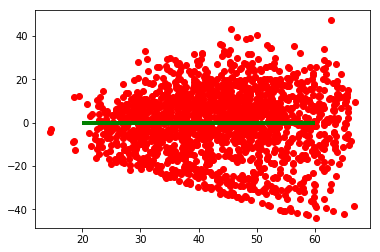

In [36]:
#residual plot to check whether errors are randomly distributed or not
plt.scatter(y_pred,(y_test-y_pred),color='r')
plt.hlines(y=0,xmin=20,xmax=60,color='g',linewidth=4)
plt.show()

It is seen that error are almost constant in nature taking a funnel like shape. so there exists heteroskedasticity .They are not random due to presence of outliers. we have already treated the outliers with sqrt tranformation

In [37]:
x=data[['Item_Visibility','Item_MRP','Item_Weight']]
y=np.sqrt(data[['Item_Outlet_Sales']])

In [38]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
len(x_train),len(x_test),len(y_train),len(y_test)

(6818, 1705, 6818, 1705)

In [39]:
lm=LinearRegression()
model=lm.fit(x_train,y_train)
y_pred=lm.predict(x_test)

In [40]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print('rmse = ',rmse)
print('R-square = ',r2)

rmse =  15.146432485193488
R-square =  0.3365173066278071


In [41]:
coeff=pd.DataFrame(x_train.columns)
coeff['coefficients']=pd.Series(lm.coef_.reshape(3,))
coeff.rename(columns={0:'predictors'})

,predictors,coefficients
0,Item_Visibility,-56.148460
1,Item_MRP,0.165719
2,Item_Weight,-0.028195


#### Item_weight is not improving the r-square,so we can drop it from the model

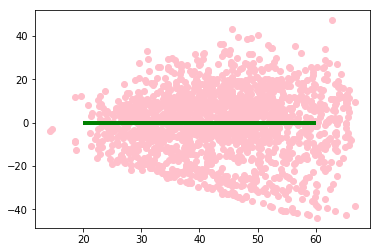

In [42]:
#residual plot to check whether errors are randomly distributed or not
plt.scatter(y_pred,(y_test-y_pred),color='pink')
plt.hlines(y=0,xmin=20,xmax=60,color='g',linewidth=4)
plt.show()

shows no improvement from the previous

In [43]:
x=x=data[['Item_Visibility','Item_MRP','Outlet_Establishment_Year']]
y=np.sqrt(data[['Item_Outlet_Sales']])

In [44]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
len(x_train),len(x_test),len(y_train),len(y_test)

(6818, 1705, 6818, 1705)

In [45]:
lm=LinearRegression()
model=lm.fit(x_train,y_train)
y_pred=lm.predict(x_test)

In [46]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print('rmse = ',rmse)
print('R-square = ',r2)

rmse =  15.147338028003956
R-square =  0.3364379704615542


In [47]:
coeff=pd.DataFrame(x_train.columns)
coeff['coefficients']=pd.Series(lm.coef_.reshape(3,))
coeff.rename(columns={0:'predictors'})

,predictors,coefficients
0,Item_Visibility,-56.084359
1,Item_MRP,0.165670
2,Outlet_Establishment_Year,-0.003463


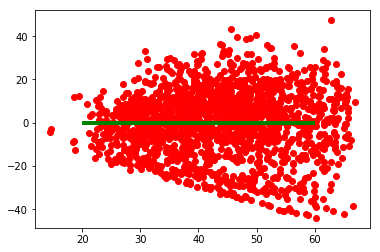

In [48]:
#residual plot to check whether errors are randomly distributed or not
plt.scatter(y_pred,(y_test-y_pred),color='r')
plt.hlines(y=0,xmin=20,xmax=60,color='g',linewidth=4)
plt.show()

Not much changes observed in the r-Sqaure nor in the residual plot from the previous.

In [49]:
x=data[['Item_Visibility','Item_MRP','Item_Type','Outlet_Size','Outlet_Establishment_Year']]
y=np.sqrt(data[['Item_Outlet_Sales']])

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
len(x_train),len(x_test),len(y_train),len(y_test)

(6818, 1705, 6818, 1705)

In [51]:
lm=LinearRegression()
model=lm.fit(x_train,y_train)
y_pred=lm.predict(x_test)

In [52]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print('rmse = ',rmse)
print('R-square = ',r2)

rmse =  14.703022468538379
R-square =  0.37479544405554077


In [53]:
coeff=pd.DataFrame(x_train.columns)
coeff['coefficients']=pd.Series(lm.coef_.reshape(5,))
coeff.rename(columns={0:'predictors'})

,predictors,coefficients
0,Item_Visibility,-46.416342
1,Item_MRP,0.165756
2,Item_Type,-0.145176
3,Outlet_Size,5.718352
4,Outlet_Establishment_Year,-0.202516


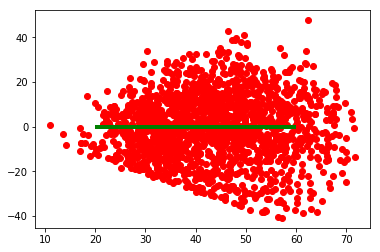

In [54]:
#residual plot to check whether errors are randomly distributed or not
plt.scatter(y_pred,(y_test-y_pred),color='r')
plt.hlines(y=0,xmin=20,xmax=60,color='g',linewidth=4)
plt.show()

#### we can see that item_type and outlet_size have significant effect on the r-square .So if we use these four predictors we have 37% info to make accurate prediction about the sales.

In [55]:
x=data[['Item_Visibility','Item_MRP','Item_Type','Outlet_Establishment_Year','Outlet_Size','Item_Fat_Content']]
y=np.sqrt(data[['Item_Outlet_Sales']])

In [56]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
len(x_train),len(x_test),len(y_train),len(y_test)

(6818, 1705, 6818, 1705)

In [57]:
lm=LinearRegression()
model=lm.fit(x_train,y_train)
y_pred=lm.predict(x_test)

In [58]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print('rmse = ',rmse)
print('R-square = ',r2)

rmse =  14.692468290029918
R-square =  0.37569269524515736


In [59]:
coeff=pd.DataFrame(x_train.columns)
coeff['coefficients']=pd.Series(lm.coef_.reshape(6,))
coeff.rename(columns={0:'predictors'})

,predictors,coefficients
0,Item_Visibility,-46.615738
1,Item_MRP,0.165724
2,Item_Type,-0.113311
3,Outlet_Establishment_Year,-0.202403
4,Outlet_Size,5.714812
5,Item_Fat_Content,0.467185


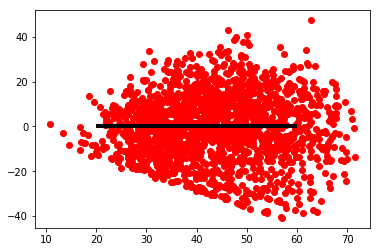

In [60]:
plt.scatter(y_pred,(y_test-y_pred),color='r')
plt.hlines(y=0,xmin=20,xmax=60,color='black',linewidth=4)
plt.show()

#### R-square seems to have improved slightly but its not that significant enough

In [61]:
x=data[['Item_Visibility','Item_MRP','Item_Type','Outlet_Size','Item_Fat_Content','Outlet_Location_Type','Outlet_Type','Outlet_Establishment_Year']]
y=np.sqrt(data[['Item_Outlet_Sales']])

In [62]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
len(x_train),len(x_test),len(y_train),len(y_test)

(6818, 1705, 6818, 1705)

In [63]:
lm=LinearRegression()
model=lm.fit(x_train,y_train)
y_pred=lm.predict(x_test)

In [64]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print('rmse = ',rmse)
print('R-square = ',r2)

rmse =  13.39936086459696
R-square =  0.4807493375768934


In [65]:
coeff=pd.DataFrame(x_train.columns)
coeff['coefficients']=pd.Series(lm.coef_.reshape(8,))
coeff.rename(columns={0:'predictors'})

,predictors,coefficients
0,Item_Visibility,-24.653043
1,Item_MRP,0.165326
2,Item_Type,-0.099491
3,Outlet_Size,-0.951166
4,Item_Fat_Content,0.475586
5,Outlet_Location_Type,4.754178
6,Outlet_Type,-7.645990
7,Outlet_Establishment_Year,0.412637


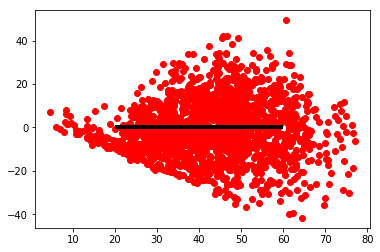

In [66]:
plt.scatter(y_pred,(y_test-y_pred),color='r')
plt.hlines(y=0,xmin=20,xmax=60,color='black',linewidth=4)
plt.show()

Addition of Outlet_Location_Type and Outlet_Type have significantly boosted the R-square. If
Item_Visibility,'Item_MRP','Item_Type','Outlet_Size','Item_Fat_Content','Outlet_Location_Type','Outlet_Type','Outlet_Establishment_Year columns are used we have 48 percent info to accurately predict the sales outcome.

# Regularisation

### Ridge Regression

In [67]:
from sklearn.linear_model import Ridge

In [68]:
X=data[data.columns.difference(['Item_Outlet_Sales'])]
Y=data['Item_Outlet_Sales']

In [69]:
X.head()

,Item_Fat_Content,Item_MRP,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Size,Outlet_Type
0,1,249.8092,1,0.016047,9.30,20,0,1,1
1,2,48.2692,3,0.019278,5.92,10,2,1,2
2,1,141.6180,1,0.016760,17.50,20,0,1,1
3,2,182.0950,1,0.000000,19.20,21,2,0,4
4,1,53.8614,1,0.000000,8.93,32,2,2,1


In [70]:
from sklearn.linear_model import Ridge

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
#create a ridge regression object object
alpha_list = [0.01,0.05,0.5,5,10]

for i in alpha_list:
    ridge_reg = Ridge(alpha = i, normalize=True)
    ridge_reg.fit(X_train, Y_train)
    y_pred1 = ridge_reg.predict(X_test)
    print("R-Sqaure {} for alpha={}" .format(r2_score(Y_test, y_pred1), i))

R-Sqaure 0.42023176361300785 for alpha=0.01
R-Sqaure 0.4182562307068117 for alpha=0.05
R-Sqaure 0.36422316339631733 for alpha=0.5
R-Sqaure 0.12631901653537803 for alpha=5
R-Sqaure 0.07210159453247522 for alpha=10


 for alpha 0.01 above model is giving more R-Square nearly 42%
 for rest of the alpha value R-Square value is decreasing

In [71]:
#fitting the model
ridge_reg = Ridge(alpha = 0.01, normalize=True)
ridge_reg.fit(X_train, Y_train)
y_pred1 = ridge_reg.predict(X_test)
r2=r2_score(Y_test,y_pred1)
r2

0.42023176361300785

In [72]:
ridge_reg.coef_

array([   47.33282023,    15.3711201 ,    -6.95968677, -2172.48018337,
          -2.96226443,    39.99744591,   394.40757749,  -113.41339076,
        -520.22528392])

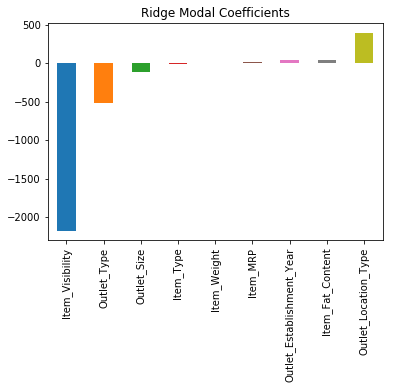

In [73]:
#checking the magnitude of coefficients
predictors = X_train.columns

coef = pd.Series([47.33282023,    15.3711201 ,    -6.95968677, -2172.48018337,
          -2.96226443,    39.99744591,   394.40757749,  -113.41339076,
        -520.22528392],predictors).sort_values()

coef.plot(kind='bar', title='Ridge Modal Coefficients')
plt.show()

R-square is maximun when alpha=0.01

# Lasso regression 

In [74]:
from sklearn.linear_model import Lasso

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
#create a ridge regression object object
alpha_list = [0.001,0.01,0.05,0.5,5,10]

for i in alpha_list:
    lasso_reg = Lasso(alpha = i, normalize=True)
    lasso_reg.fit(X_train, Y_train)
    y_pred2 = lasso_reg.predict(X_test)
    print("R-Square {} for alpha={}" .format(r2_score(Y_test, y_pred2), i))

R-Square 0.420335429384033 for alpha=0.001
R-Square 0.42031828233232693 for alpha=0.01
R-Square 0.4201205926056898 for alpha=0.05
R-Square 0.41310685675931613 for alpha=0.5
R-Square 0.25702911787745186 for alpha=5
R-Square 0.08675970968730762 for alpha=10


In [75]:
# Fit the model using alpha 0.001

lasso_reg = Lasso(alpha = 0.05, normalize=True)
lasso_reg.fit(X_train, Y_train)
y_pred2 = lasso_reg.predict(X_test)
print("R-Square: ",r2_score(Y_test, y_pred2))

R-Square:  0.4201205926056898


In [76]:
lasso_reg.coef_

array([ 3.99244504e+01,  1.54606562e+01, -3.62749790e+00, -2.09668891e+03,
       -2.08844216e+00,  3.93835887e+01,  3.88123119e+02, -1.00963034e+02,
       -5.18362040e+02])

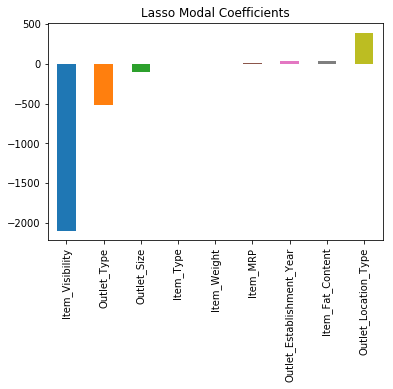

In [77]:
#checking the magnitude of coefficients

predictors = X_train.columns

coef = pd.Series([3.99244504e+01,  1.54606562e+01, -3.62749790e+00, -2.09668891e+03,
       -2.08844216e+00,  3.93835887e+01,  3.88123119e+02, -1.00963034e+02,
       -5.18362040e+02],
              predictors).sort_values()

coef.plot(kind='bar', title='Lasso Modal Coefficients')
plt.show()

* clearly observe that when alpha 0.001 the R-Squre value is maximum
* In lasso if we increase the alpha co-efficient will reach to absolute zero
* It is a kind of features extraction, it will select the column according to its dependancy on sales

# Prediction of sales using test data

In [78]:
test=pd.read_csv('test.csv')
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [79]:
#dropping two columns as we have dropped train test also
test.drop(["Item_Identifier","Outlet_Identifier"], axis=1, inplace=True)

In [80]:
test.shape

(5681, 9)

In [81]:
#percentage of null values
test.isnull().sum()/len(test)

Item_Weight                  0.171801
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282697
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
dtype: float64

In [82]:
#grouping the data similar to what we did for train data
test["Item_Weight"] = imputer.fit_transform(test[["Item_Weight"]])
test["Item_Fat_Content"] = test["Item_Fat_Content"].replace({'Low Fat':'LF','low fat':'LF','Regular':'RF','reg':'RF'})
test["Outlet_Establishment_Year"] = 2019 - test.Outlet_Establishment_Year
test["Item_Type"] = test["Item_Type"].replace({'Fruits and Vegetables':'grocery','Snack Foods':'snacks',
             'Household':'grocery','Frozen Foods':'snacks','Dairy':'grocery','Canned':'grocery','Baking Goods':'grocery',
            'Health and Hygiene':'health','Soft Drinks':'drinks','Meat':'grocery','Breads':'grocery','Hard Drinks':'drinks',
            'Others':'others','Starchy Foods':'others','Breakfast':'others','Seafood':'grocery'})
test["Outlet_Size"] = test["Outlet_Size"].replace({np.nan:"Small"})

In [83]:
#converting the categorical columns to numerical
test['Item_Fat_Content']=test['Item_Fat_Content'].map({'LF':1,'RF':2})
test['Item_Type']=test['Item_Type'].map({'grocery':1,'snacks':2,'drinks':3,'health':4,'others':5})
test['Outlet_Size']=test['Outlet_Size'].map({'Small':0,'Medium':1,'High':2})
test['Outlet_Location_Type']=test['Outlet_Location_Type'].map({'Tier 3':2,'Tier 2':1,'Tier 1':0})
test['Outlet_Type']=test['Outlet_Type'].map({'Supermarket Type1':1,'Supermarket Type2':2,'Supermarket Type3':3,'Grocery Store':4})

In [84]:
test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,20.750000,1,0.007565,2,107.8622,20,1,0,1
1,8.300000,2,0.038428,1,87.3198,12,0,1,1
2,14.600000,1,0.099575,5,241.7538,21,0,2,4
3,7.315000,1,0.015388,2,155.0340,12,0,1,1
4,12.695633,2,0.118599,1,234.2300,34,1,2,3


In [85]:
# from the test data set also we are taking those columns wchich were giving maximum R-Squre for training dataset
x_test = test[['Item_Visibility','Item_MRP','Item_Type','Outlet_Size','Item_Fat_Content','Outlet_Location_Type',
                     'Outlet_Type','Outlet_Establishment_Year']]

In [86]:
# Previously we have done squre root transform of our Sales so, to get back original sales value 
# for test dataset ,so we will do square root tranform again during prediction to get back origanal sales values

#predicting "Item_Outlet_Sales" for test data and adding it to the original dataset
test["Item_Outlet_Sales"] = (lm.predict(x_test))**2 

In [87]:
test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,20.750000,1,0.007565,2,107.8622,20,1,0,1,1447.044164
1,8.300000,2,0.038428,1,87.3198,12,0,1,1,1358.829225
2,14.600000,1,0.099575,5,241.7538,21,0,2,4,2074.181598
3,7.315000,1,0.015388,2,155.0340,12,0,1,1,2308.814973
4,12.695633,2,0.118599,1,234.2300,34,1,2,3,3222.032975


### So we have predicted the Item_Outlet_Sales with 48% accuracy and rmse of 13.399 using the best linear regression model .These feature will give 48% info in predicting the sales accurately.